# Exam: Exercise 6 - Dormand Prince 5(4)

### 6.1 Description and Stability

In [3]:
import numpy as np
import matplotlib.pyplot as plt

s, p = 7, 4 # stages s; order p

# Coefficients for Dormand-Prince method
c2, c3, c4, c5, c6, c7 = 1/5, 3/10, 4/5, 8/9, 1, 1
a21 = 1/5
a31, a32 = 3/40, 9/40
a41, a42, a43 = 44/45, -56/15, 32/9
a51, a52, a53, a54 = 19372/6561, -25360/2187, 64448/6561, -212/729
a61, a62, a63, a64, a65 = 9017/3168, -355/33, 46732/5247, 49/176, -5103/18656
a71, a72, a73, a74, a75, a76 = 35/384, 0, 500/1113, 125/192, -2187/6784, 11/84

b1, b2, b3, b4, b5, b6, b7 = 35/384, 0, 500/1113, 125/192, -2187/6784, 11/84, 0
b1p, b2p, b3p, b4p, b5p, b6p, b7p = 5179/57600, 0, 7571/16695, 393/640, -92097/339200, 187/2100, 1/40

# coefficient matrices and vectors
A = np.array([
    [0, 0, 0, 0, 0, 0, 0],
    [a21, 0, 0, 0, 0, 0, 0],
    [a31, a32, 0, 0, 0, 0, 0],
    [a41, a42, a43, 0, 0, 0, 0],
    [a51, a52, a53, a54, 0, 0, 0],
    [a61, a62, a63, a64, a65, 0, 0],
    [a71, a72, a73, a74, a75, a76, 0],
])

c = np.array([0, c2, c3, c4, c5, c6, c7]).reshape(-1,1)
b = np.array([b1, b2, b3, b4, b5, b6, b7]).reshape(-1,1)
b_ = np.array([b1p, b2p, b3p, b4p, b5p, b6p, b7p]).reshape(-1,1)
e = np.array([71/57600,  0, -71/16695, 71/1920, -17253/339200, 22/525, -1/40]).reshape(-1,1)

In [111]:
# R(z) = 1 + z b^T(Id - z A)^{-1} e

re = np.linspace(-5, 5, 500)
im = np.linspace(-5, 5, 500)
rev, imv = np.meshgrid(re, im)

z = np.array([complex(r,i) for r, i in zip(rev.flatten(), imv.flatten())]).reshape(500, 500)
R = lambda z: 1 + np.inner(z,b.T)@np.linalg.inv(np.eye(len(A)) - z*A)@e
R = lambda z: 1 + np.inner(z,b.T)@np.linalg.inv(np.eye(len(A)) - z*A)@np.ones(len(A))
#R = lambda z: 1 + np.inner(z,b.T)@np.linalg.solve((np.eye(len(A))-z*A), np.ones(len(b)))
Rz = np.array([R(z_) for z_ in z.flatten()])

For $R(z)$ two formulas are given. One in math writing p.25 and one in a **matlab** implementation p.26-27 (in *Lecture 8B*)

1. $R(z) = 1 + z b^T(Id - z A)^{-1} e$
2. $R(z) = 1 + z b^T ((Id - z A) \Delta \mathbf{1})$

where $\Delta$ is the 'solve for ...' operator, hence $A \Delta b = x$ comes from $Ax = b \Leftrightarrow x = A^{-1}b$. 

But the two equations are not mathematically equivalent and yield very different results for a stability analysis.

Which one is the correct one then?

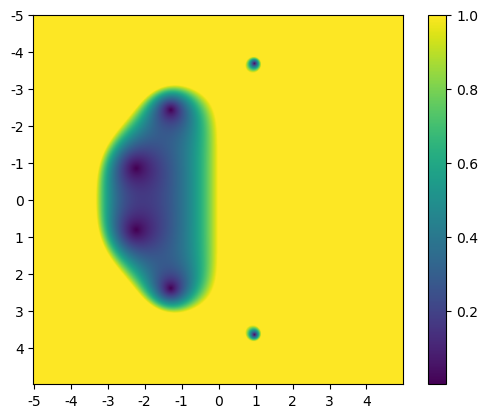

In [112]:
plt.imshow(np.abs(Rz.reshape(500,500)).clip(max=1))
plt.colorbar()
plt.xticks(ticks=np.arange(0, 500, 50), labels=np.arange(-5,5,1));
plt.yticks(ticks=np.arange(0, 500, 50), labels=np.arange(-5,5,1));
#plt.yticks(np.arange(-5, 5, 1))

In [ ]:
def RK_stability(A:np.ndarray, b:np.ndarray, err_vec:np.ndarray, grid_size:int=5, pixels:int=500) -> tuple:
    x, y = np.linspace(-grid_size, grid_size, pixels), np.linspace(-grid_size, grid_size, pixels)
    X, Y = np.meshgrid(x, y)
    Z = X + 1j*Y

    absR, absEhat, absEhatmE, absE, absF = [], [], [], [], []
    for z in Z.flatten():
        A_inv_ = np.linalg.solve((np.eye(len(A))-z*A), np.ones(len(b)))
        R = 1+np.inner(z,b.T)@A_inv_
        Ehat = np.inner(z,err_vec.T)@A_inv_
        E = R-np.exp(z)
        absR.append(np.abs(R))
        absEhat.append(np.abs(Ehat))
        absEhatmE.append(np.abs(Ehat-E))
        absE.append(np.abs(E))
        absF.append(np.abs(np.exp(z)))
    absR = np.array(absR).reshape(pixels, pixels)
    absEhat = np.array(absEhat).reshape(pixels, pixels)
    absEhatmE = np.array(absEhatmE).reshape(pixels, pixels)
    absE = np.array(absE).reshape(pixels, pixels)
    absF = np.array(absF).reshape(pixels, pixels)
    
    return absR, absEhat, absEhatmE, absE, absF

def plot_rk_stability(A:np.ndarray, b:np.ndarray, err_vec:np.ndarray, grid_size:int=5, pixels:int=500):
    absR, absEhat, absEhatmE, absE, absF = RK_stability(A, b, err_vec, grid_size, pixels)

    fig = plt.figure(figsize=(10,4), dpi=400)
    
    plt.subplot(1,2,1)
    plt.title('$|R(z)|$')
    plt.imshow(absR.clip(max=1))
    plt.axvline(pixels//2, color='r')
    plt.axhline(pixels//2, color='r')
    plt.xticks(ticks=np.arange(0, pixels, 50), labels=np.arange(-grid_size, grid_size,1))
    plt.yticks(ticks=np.arange(0, pixels, 50), labels=np.arange(-grid_size, grid_size,1))
    plt.xlabel("$Re(z)$")
    plt.ylabel("$Im(z)$")

    plt.subplot(2,4,3)
    plt.title('$|\hat{E}(z)|$')
    plt.xticks(ticks=np.arange(0, pixels, 50), labels=[])
    plt.yticks(ticks=np.arange(0, pixels, 50), labels=[])
    plt.imshow(absEhat.clip(max=1))
    plt.subplot(2,4,4)
    plt.title('$|exp(z)|$')
    plt.imshow(absF.clip(max=1))
    plt.xticks(ticks=np.arange(0, pixels, 50), labels=[])
    plt.yticks(ticks=np.arange(0, pixels, 50), labels=[])
    plt.subplot(2,4,7)
    plt.title('$|E(z)|$')
    plt.imshow(absE.clip(max=1))
    plt.xticks(ticks=np.arange(0, pixels, 50), labels=[])
    plt.yticks(ticks=np.arange(0, pixels, 50), labels=[])
    plt.subplot(2,4,8)
    #plt.title('$|E(z) - \hat{E}(z)|$')
    plt.legend(['hello'])
    plt.imshow(absEhatmE.clip(max=1))
    plt.xticks(ticks=np.arange(0, pixels, 50), labels=[])
    plt.yticks(ticks=np.arange(0, pixels, 50), labels=[])

    fig.subplots_adjust(right=0.8, hspace=0.1, wspace=0.1)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(plt.imshow(absR.clip(max=1)), cax=cbar_ax)

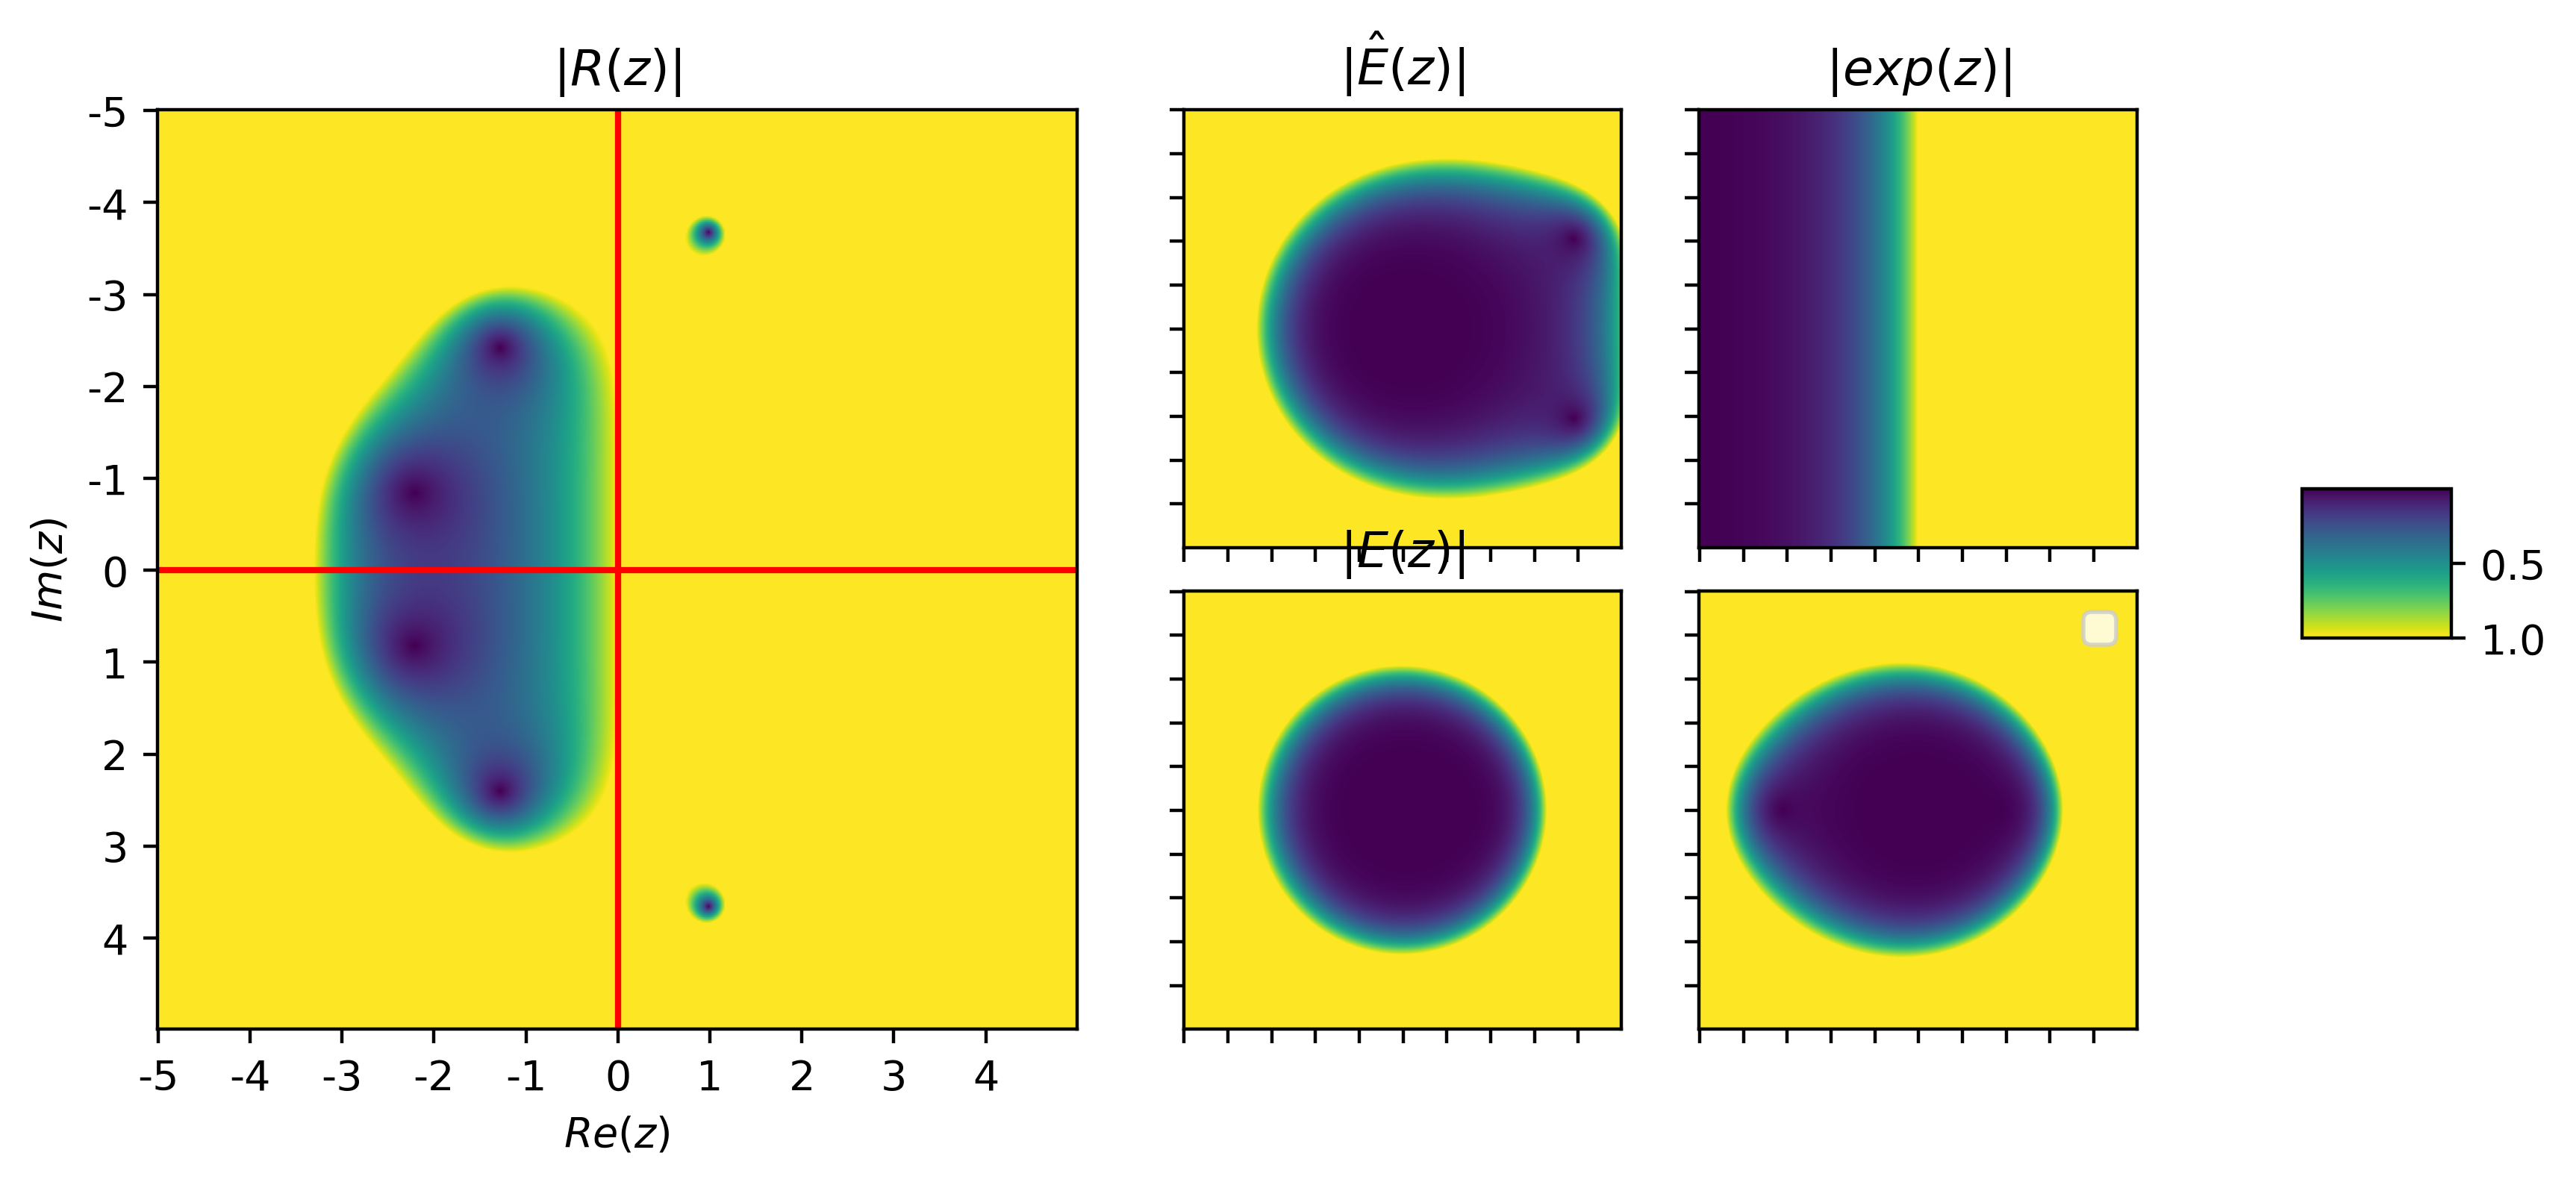

In [188]:
plot_rk_stability(A, b, e)